# Домашнее задание 2
<!-- - В работе следует использовать библиотеку scikit-learn версии 0.18 и scipy версии 0.18.1 -->

Используя датасет [STUDENT ALCOHOL CONSUMPTION](https://github.com/grafft/hse-tasks/blob/master/minor-aml-17/hw2/data.zip) и статью ["USING DATA MINING TO PREDICT SECONDARY SCHOOL STUDENT ALCOHOL CONSUMPTION"](https://github.com/grafft/hse-tasks/blob/master/minor-aml-17/hw2/paper.pdf) выполните задания.

In [1]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (12,6)
plt.rc('font', family='Arial')
# plt.style.use('ggplot')

np.set_printoptions(suppress=True)

Wall time: 3.63 s


In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

In [3]:
df_mat = pd.read_csv(r"data/student-mat.csv", sep=';')
df_por = pd.read_csv(r"data/student-por.csv", sep=';')
print(f"Number of features: {df_mat.shape[1]} and {df_por.shape[1]}")
print(f"df_mat count: {df_mat.shape[0]}\ndf_por count: {df_por.shape[0]}")

Number of features: 33 and 33
df_mat count: 395
df_por count: 649


Объединение таблиц по аналогии с приложенным к статье R-файлом.

*В дополнение к пересекающимся признакам, указанным в R-файле, при объединении указаны все остальные признаки, совпадающие для одного человека (не зависящие от предмета), а именно: `Dalc`, `Walc`, `guardian`, `health`, `famrel`, `higher`, `romantic`, `goout`, `freetime`, `famsup`, `schoolsup`, `studytime`, `activities`, `traveltime`. При этом, после указания первых двух признаков, число студентов сократилось с первоначальных 382 до 370.*

In [4]:
df = pd.merge(df_mat, df_por, on=list(set(df_mat.columns) - {'absences', 'G3', 'failures', 'G1', 'paid', 'G2'}))
df.shape

(370, 39)

В набор объединенных данных следущие признаки попали дважды (различаются для курсов математики и португальского):

In [5]:
print(set(df_por.columns) - set(df.columns))

{'failures', 'G1', 'G3', 'G2', 'paid', 'absences'}


Набор всех моделей с исходным пространством признаков.

In [6]:
dataframes = {
    "mat": df_mat,
    "por": df_por
}

## Предобработка (Max 2)
### Приведите описание признаков датасета на русском языке с указанием типа данных (0.3 балла)

#### Признаки

1. `school` - место обучения, **бинарный** ("GP" - Gabriel Pereira/"MS" - Mousinho da Silveira)
2. `sex` - пол, **бинарный** ("F" - женский/"M" - мужской)
3. `age` - возраст, **числовой** от 15 до 22
4. `address` - тип места жительства, **бинарный** ("U" - городской/"R" - сельский)
5. `famsize` - размер семьи, **бинарный** ("LE3" если <= 3/"GT3" если > 3)
6. `Pstatus` - статус сожительства родителей, **бинарный** ("T" - живут вместе/"A" - живут отдельно)
7. `Medu` - образование матери, **числовой** (0 - без,  1 - начальное (4 класса), 2 – старшая школа (5-9 класс), 3 – среднее, 4 – высшее)
8. `Fedu` - образование отца, **числовой** (0 - без,  1 - начальное (4 класса), 2 – старшая школа (5-9 класс), 3 – среднее, 4 – высшее)
9. `Mjob` - место работы матери, **категориальный** ("teacher"/"health" - здравоохранение/"services" - гражданские услуги (например, администрация или полиция)/"at_home"/"other")
10. `Fjob` - место работы отца, **категориальный** ("teacher"/"health" - здравоохранение/"services" - гражданские услуги (например, администрация или полиция)/"at_home"/"other")
11. `reason` - причина выбора данной школы, **категориальный** ("home" - близость к месту жительства/"reputation" - репутация школы/"course" - предпочтительные курсы/"other")
12. `guardian` - покровитель, **категориальный** ("mother"/"father"/"other")
13. `traveltime` - длительность дороги от школы до до дома, **числовой** (1 - < 15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. `studytime` - количество учебных часов в неделю, **числовой** (1 - < 2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. `failures` - число заваленных в прошлом предметов, **числовой** (n если 1 <= n < 3, иначе 4)
16. `schoolsup` - дополнительная образовательная поддержка, **бинарный** (yes/no)
17. `famsup` - семейная образовательная поддержка, **бинарный** (yes/no)
18. `paid` - дополнительные платные занятия по данному предмету (Math or Portuguese), **бинарный** (yes/no)
19. `activities` - внеклассные занятия, **бинарный** (yes/no)
20. `nursery` - посещал детский сад, **бинарный** (yes/no)
21. `higher` - желание получить высшее образование, **бинарный** (yes/no)
22. `internet` - доступ в интернет дома, **бинарный** (yes/no)
23. `romantic` - в отношениях, **бинарный** (yes/no)
24. `famrel` - уровень отношений в семье, **числовой** (от 1 - очень плохо, до 5 - отлично)
25. `freetime` - свободное время после занятий, **числовой** (от 1 - очень низко, до 5 - очень высоко)
26. `goout` - прогулки с друзьями, **числовой** (от 1 - очень низко, до 5 - очень высоко)
27. `Dalc` - потребление алкоголя в течение недели, **числовой** (от 1 - очень низко, до 5 - очень высоко)
28. `Walc` - потребление алкоголя по выходным, **числовой** (от 1 - очень низко, до 5 - очень высоко)
29. `health` - текущее состояние здоровья, **числовой** (от 1 - очень плохо, до 5 - очень хорошо)
30. `absences` - число пропусков школы, **числовой** (от 0 до 93)

#### Данные оценки связаны с темой курса (математика/португальский)
* `G1` - оценка первого модуля, **числовой** (от 0 до 20)
* `G2` - оценка второго модуля, **числовой** (от 0 до 20)
* `G3` - итоговая оценка, **числовой** (от 0 до 20) <== **целевая переменная**

*382 ученика принадлежат обоим наборам данных. Их можно обнаружить по общим аттрибутам (признакам).*

Признаки, относящиеся к конкретному предмету: `absences`, `G3`, `failures`, `G1`, `paid`, `G2`.

Объединение по данным признакам приводит к сокращению числа учеников, принадлежащих обоим группам, до 370 человек.

Всего в наборе для каждого объекта указано:
* 13 бинарных признаков
* 16 числовых признака (в том числе целевая переменная)
* 4 категориальных признака: `Mjob`, `Fjob`, `reason`, `guardian`.

### Предобработка данных (1.7)
- Проверьте наличие пропусков. В случае наличия пропусков заполните их медианными значениями (0.4)
- Подсчитайте количество людей, у которых матери с образованием "0" (0.4)
- Преобразуйте все номинальные признаки в несколько признаков с бинарным значение (0.4)

Явные пропуски в данных отсутствуют.

In [7]:
print(f"merged: {df.isnull().values.any()}")
for name, x_ in dataframes.items():
    print(f"{name}: {x_.isnull().values.any()}")

merged: False
mat: False
por: False


Поиск бинарных признаков в выборке (замена на 0/1).

In [8]:
for feature in df.columns:
    vals = pd.unique(df[feature].values)
    if vals.shape[0] == 2:
        print(f"'{feature}': {vals[0]} is now 1")
        df[feature] = (df[feature] == vals[0]).apply(int)

'school': GP is now 1
'sex': F is now 1
'address': U is now 1
'famsize': GT3 is now 1
'Pstatus': A is now 1
'schoolsup': yes is now 1
'famsup': no is now 1
'paid_x': no is now 1
'activities': no is now 1
'nursery': yes is now 1
'higher': yes is now 1
'internet': no is now 1
'romantic': no is now 1
'paid_y': no is now 1


In [9]:
for feature in df_por.columns:
    vals = pd.unique(df_por[feature].values)
    if vals.shape[0] == 2:
        print(f"'{feature}': {vals[0]} is now 1")
        for name in dataframes:
            dataframes[name][feature] = (dataframes[name][feature] == vals[0]).apply(int)

'school': GP is now 1
'sex': F is now 1
'address': U is now 1
'famsize': GT3 is now 1
'Pstatus': A is now 1
'schoolsup': yes is now 1
'famsup': no is now 1
'paid': no is now 1
'activities': no is now 1
'nursery': yes is now 1
'higher': yes is now 1
'internet': no is now 1
'romantic': no is now 1


Бинарные признаки соответствуют имеющимся в описании -> не содержат пропусков (так как определение бинарности признака происходило по подсчету вариантов его значения).

Категориальные признаки содержат вариант "other" -> не содержат пропусков (неизвестные значения попадают в "прочее").

In [10]:
for features in (pd.unique(df_por['Mjob'].values), pd.unique(df_por['Fjob'].values),
                 pd.unique(df_por['reason'].values), pd.unique(df_por['guardian'].values)):
    if "other" not in features:
        raise ValueError("No 'other' in features")

Проанализироваа числовые признаки можно сказать, что пропуски может содержать только признак `failures` (из-за наличия условия). Однако, пропуски отсутствуют.

In [11]:
df['failures_y'].value_counts()

0    338
1     21
3      6
2      5
Name: failures_y, dtype: int64

На объединенных данных y 3-х учеников матери не имеют никакого образования, а на всех - у 9-ти. Следовательно, всего у 6ти учеников матери не имеют высшего образования.

In [12]:
print(f"number of students with Medu = 0 in merged table: {df[df['Medu'] == 0].shape[0]}")
print(f"number of students with Medu = 0 for por: {df_por[df_por['Medu'] == 0].shape[0]}")
print(f"number of students with Medu = 0 for math: {df_mat[df_mat['Medu'] == 0].shape[0]}")

number of students with Medu = 0 in merged table: 3
number of students with Medu = 0 for por: 6
number of students with Medu = 0 for math: 3


Преобразование категориальных признаков с помощью one-hot кодирования.

In [13]:
df = pd.get_dummies(df, columns=["Mjob", "Fjob", "guardian", "reason"])

for name, x_ in dataframes.items():
    dataframes[name] = pd.get_dummies(x_, columns=["Mjob", "Fjob", "guardian", "reason"])

Извлечение целевой переменной.

In [14]:
X = df.drop(["G3_x", "G3_y"], axis=1)
y = df.loc[:, ("G3_x", "G3_y")]

print(f"X: {X.shape}, y: {y.shape}")

X: (370, 50), y: (370, 2)


In [15]:
X_m, y_m = {}, {}
for name, x_ in dataframes.items():
    X_m[name] = x_.drop("G3", axis=1)
    y_m[name] = x_.loc[:, "G3"]
    print(f"{name} :: X{X_m[name].shape}, y{y_m[name].shape}")

mat :: X(395, 45), y(395,)
por :: X(649, 45), y(649,)


#### Используя объект [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) с параметром [f_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)  выберите два признака, которые наиболее сильно связаны с признаком G3 (0.5)

In [16]:
from sklearn.feature_selection import SelectKBest, f_regression

In [17]:
selector = SelectKBest(f_regression, k=4)  # 4 is for curiosity

# for df_mat, df_por
for (name, x_), y_ in zip(X_m.items(), y_m.values()):
    selector = selector.fit(x_, y_)
    idx = selector.get_support()
    print(f"{name}:: features{x_.columns[idx].values}, weights{selector.scores_[idx]}")

# for merged data
for name in y.columns:
    selector = selector.fit(X, y.loc[:, name])
    idx = selector.get_support()
    print(f"{name}:: features{X.columns[idx].values}, weights{selector.scores_[idx]}")

mat:: features['Medu' 'failures' 'G1' 'G2'], weights[   19.44818367    58.67166578   705.84224711  1775.7075456 ]
por:: features['failures' 'higher' 'G1' 'G2'], weights[  118.40612313    80.24245288  1393.46671256  3493.28156639]
G3_x:: features['G1_x' 'G2_x' 'G1_y' 'G2_y'], weights[  678.09808872  1699.65126214   130.68018719   160.47626993]
G3_y:: features['G1_x' 'G2_x' 'G1_y' 'G2_y'], weights[  167.7096323    132.95484715   743.74911923  1397.38621299]


Для всех выборок наиболее влияющими на целевую переменную признаками оказались (по очевидным причинам) оценки за предыдущие модули (G1, G2). 

Интересно то, что оценки по другому предмету коррелируют с оценками по данному больше, чем остальные признаки (видно из объединенного набора данных). 

### Регрессия (Max 4)
Выберите один признак, который наиболее влияет на признак G3 и используя кросс-валидацию (cross-validation) выполните следующее:

Наиболее влияющий на G3 признак - G2 (для всех вариантов наборов даных).

In [18]:
X = X.loc[:, ("G2_x", "G2_y")]
for name, x_ in X_m.items():
    X_m[name] = x_.loc[:, "G2"].values.reshape(-1, 1)

Деление выборки на обучающую и контрольную.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_g3_train, X_g3_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print(f"train::{y_train.shape[0]}, test::{y_test.shape[0]}")

train::296, test::74


In [21]:
X_g3_s, y_g3_s = {}, {}  # s - splited
for (name, x_), y_ in zip(X_m.items(), y_m.values()):
    X_g3_s[name], y_g3_s[name] = {}, {}
    X_g3_s[name]['train'], X_g3_s[name]['test'], y_g3_s[name]['train'], y_g3_s[name]['test'] = train_test_split(
        x_, y_, test_size=0.3, random_state=RANDOM_SEED)
    print(f"{name} :: train::{y_g3_s[name]['train'].shape[0]}, test::{y_g3_s[name]['test'].shape[0]}")

mat :: train::276, test::119
por :: train::454, test::195


In [22]:
X_g3_s['merged'] = {
    'test': X_g3_test,
    'train': X_g3_train
}
y_g3_s['merged'] = {
    'test': y_test,
    'train': y_train
}

#### Обучение RidgeСV (Max (0.5))
- На обучающей выборке обучите объект [RidgeСV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для различных alpha (0.2)
- Выберите alpha при котором RidgeCV лучше всего предсказывает значения (0.1)
- Подсчитайте метрику mean absolute error, mean squared error, median absolute error,r2 score(0.2)

Все модели будем оценивать на 3х фолдах при помощи MSE.

In [23]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, median_absolute_error, r2_score

In [24]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
fold = 3

In [25]:
%%time
rcv = RidgeCV(alphas=np.logspace(-5, 5, 100), cv=fold, scoring=scorer)

for (name, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
    rcv = rcv.fit(x_['train'], y_['train'])
    
    y_hat = rcv.predict(x_['test'])
    mse = mean_squared_error(y_['test'], y_hat)
    mae = mean_absolute_error(y_['test'], y_hat)
    r2 = rcv.score(x_['test'], y_['test'])
    try:
        medae = median_absolute_error(y_['test'], y_hat)
    except ValueError:
        print(f"{name} has error with median_absolute_score", file=sys.stderr)
        medae = None
    print(f"{name}:: alpha={rcv.alpha_}\n\tmae::\t{mae}\n\tmse::\t{mse}\n\tr2::\t{r2}\n\tmedian::\t{medae}")    

mat:: alpha=14.508287784959402
	mae::	1.2069719909812968
	mse::	4.080468760644505
	r2::	0.8248835715773253
	median::	0.7651396507449366
por:: alpha=1e-05
	mae::	0.7703220022024387
	mse::	1.5003912419717107
	r2::	0.8532656309289935
	median::	0.5830091954517833
merged:: alpha=14.508287784959402
	mae::	1.0141604344430144
	mse::	2.751564266966804
	r2::	0.8286267346138905
	median::	None
Wall time: 1.93 s


merged has error with median_absolute_score


$R^{2}\to{1}$, следовательно, модель хорошо предсказывает данные.

#### Обучение SGDRegressor (Max (0.5))
- Создайте объекты [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor), используя все возможных варианты аргумента penalty (0.2)
- Обучите все полученных объекты на обучающей выборке (0.1)
- Подсчитайте метрику r2 score для всех объектов (0.2)

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [27]:
%%time
rgdrcv = GridSearchCV(
    SGDRegressor(max_iter=1000, random_state=RANDOM_SEED),
    param_grid=dict(penalty=['none', 'l2', 'l1', 'elasticnet']),
    scoring=scorer,
    cv=fold
)

for (name, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
    try:
        rgdrcv = rgdrcv.fit(x_['train'], y_['train'])
    except ValueError:
        print(f"Can't fit model: '{name}'", file=sys.stderr)
        continue
    y_hat = rgdrcv.predict(x_['test'])
    mse = mean_squared_error(y_['test'], y_hat)
    mae = mean_absolute_error(y_['test'], y_hat)
    r2 = rgdrcv.score(x_['test'], y_['test'])
    print(f"{name}:: penalty={rgdrcv.best_estimator_.penalty}\n\tmae::\t{mae}\n\tmse::\t{mse}\n\tr2::\t{r2}")

mat:: penalty=l2
	mae::	1.2515566057877188
	mse::	4.112608544021262
	r2::	-4.112608544021262
por:: penalty=none
	mae::	0.7534346522665278
	mse::	1.507372833000704
	r2::	-1.507372833000704
Wall time: 687 ms


Can't fit model: 'merged'


Как видно, модель не способна делать предсказания на объединенной выборке (с несколькими целевыми переменными).

$R^{2}<{0}$ - модель плохо предсказывает данные. Попытка обучить модель со стандартным значением `scoring` для модели.

In [28]:
%%time
rgdrcv = rgdrcv.set_params(scoring=r2_scorer)

for (name, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
    try:
        rgdrcv = rgdrcv.fit(x_['train'], y_['train'])
    except ValueError:
        print(f"Can't fit model: '{name}'", file=sys.stderr)
        continue
    y_hat = rgdrcv.predict(x_['test'])
    mse = mean_squared_error(y_['test'], y_hat)
    mae = mean_absolute_error(y_['test'], y_hat)
    r2 = rgdrcv.score(x_['test'], y_['test'])
    print(f"{name}:: penalty={rgdrcv.best_estimator_.penalty}\n\tmae::\t{mae}\n\tmse::\t{mse}\n\tr2::\t{r2}")

mat:: penalty=l2
	mae::	1.2515566057877188
	mse::	4.112608544021262
	r2::	0.8235042682655345
por:: penalty=none
	mae::	0.7534346522665278
	mse::	1.507372833000704
	r2::	0.8525828494476748
Wall time: 672 ms


Can't fit model: 'merged'


Лучшим вариантом `penalty` для выбранных моделей оказывается отказ от штрафа - возможно, модель быстро переобучается (признак `G2` хорошо коррелирует с `G3`).

Получение $R^{2}$ для всех вариантов `penalty`.

In [29]:
%%time
for (name, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
    try:
        rgdrcv = rgdrcv.fit(x_['train'], y_['train'])
    except ValueError:
        print(f"Can't fit model: '{name}'", file=sys.stderr)
        continue
    print(f"{name}:")
    for val, score in zip(rgdrcv.cv_results_['param_penalty'].data, 
                          rgdrcv.cv_results_['mean_test_score']):
        print(f"\t{val}::\t{score}")

mat:
	none::	0.8121224297416936
	l2::	0.8121226191344728
	l1::	0.812122589083318
	elasticnet::	0.812122614626857
por:
	none::	0.8302254579989227
	l2::	0.8302252553706588
	l1::	0.8302252364246107
	elasticnet::	0.8302252525287871
Wall time: 703 ms


Can't fit model: 'merged'


#### Обучение SGDRegressor (Max (0.5))
- Создайте объекты с параметрами max_depth = 1,3, 10 [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) и для каждого объекта изменяйте количество n_estimators  от 100 до 1000 с шагом 100 (0.2)
- Подсчитайте метрику r2 score для всех объектов (0.1)
- Визуализируйте зависимость R2 oт n_estimators на графике (0.2)

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

mat:
	depth=1:: scores[0.80434273886314211, 0.80375282838412787, 0.80334520074128468, 0.80309336084305427, 0.80294132540739793, 0.80285136425518544, 0.80279208825229631, 0.80275823034063787, 0.80273824027345864, 0.8027265831408682]
	depth=3:: scores[0.80271511352302194, 0.80270934501212354, 0.80270934403129612, 0.80270934403101846, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823]
	depth=10:: scores[0.80271040125567139, 0.80270934405911543, 0.8027093440310189, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823, 0.80270934403101823]
por:
	depth=1:: scores[0.82626462171469561, 0.82172420866501128, 0.81847693367556673, 0.81653605615363256, 0.81540612957329095, 0.81474927766268213, 0.81438192672900345, 0.81417843771338472, 0.81406573297453855, 0.81400228856131007]
	depth=3:: scores[0.81394098674020043, 0.8139214797903318, 0.81392147671547921,

Can't fit model: 'merged'


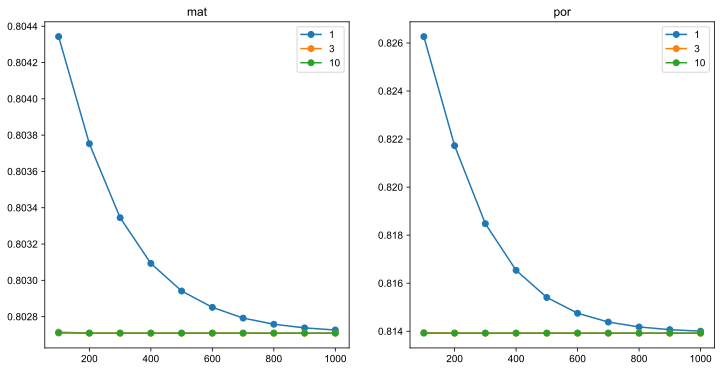

In [31]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
gbrcv = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    param_grid=dict(n_estimators=np.linspace(100, 1000, 10, dtype=int),
                    max_depth=(1, 3, 10)),
    scoring=r2_scorer,
    cv=3
)

x_axis = np.linspace(100, 1000, 10, dtype=int)
for idx, ((name, x_), y_) in enumerate(zip(X_g3_s.items(), y_g3_s.values())):
    try:
        gbrcv = gbrcv.fit(x_['train'], y_['train'])
    except ValueError:
        print(f"Can't fit model: '{name}'", file=sys.stderr)
        continue
    params = {}
    for i, param in enumerate(gbrcv.cv_results_['params']):
        if param['max_depth'] not in params:
            params[param['max_depth']] = []
        params[param['max_depth']].append(gbrcv.cv_results_['mean_test_score'][i])
    print(f"{name}:")
    for depth, scores in params.items():
        print(f"\tdepth={depth}:: scores{scores}")
        __ = ax[idx].plot(x_axis, scores, '-o')
    __ = ax[idx].legend(params.keys())
    __ = ax[idx].set_title(name)

Странно, что доля объясненной дисперсии $R^{2}$ падает с ростом числа деревьев глубиной 1 для исходных наборов данных.

#### Используя все доступные регрессоры в библиотеке sklearn, найдите самый лучший регрессор. (2.5)

Все возможные регрессоры в sklearn (которые я смог найти).

In [32]:
from sklearn.linear_model import (
    ARDRegression, HuberRegressor, LinearRegression, PassiveAggressiveRegressor, 
    TheilSenRegressor, RANSACRegressor, ridge_regression
)
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, regression, RadiusNeighborsRegressor, regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.isotonic import isotonic_regression, IsotonicRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.dummy import DummyRegressor

Выбор лучшего регрессора производится из следующих:
* ансамбли решающих деревьев:
    * `RandomForestRegressor`
    * `BaggingRegressor`
    * `GradientBoostingRegressor`
    * `ExtraTreesRegressor`
    * `AdaBoostRegressor`
* метод опорных векторов:
    * `SVR`
    * `NuSVR`

<!--
* с использованием нейросетевых методов:
    * `MLPRegressor` - не используется при подборе параметров из-за их большого числа (очень долго)
-->

In [33]:
models_r = {
    'RandomForest': RandomForestRegressor(random_state=RANDOM_SEED),
    'Bagging': BaggingRegressor(random_state=RANDOM_SEED),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_SEED),
    'ExtraTrees': ExtraTreeRegressor(random_state=RANDOM_SEED),
    'AdaptiveBoosting': AdaBoostRegressor(random_state=RANDOM_SEED),
    'SupportVector': SVR(),
    'NuSVR': NuSVR()
}

**Примечание:** для метрики $R^{2}$ я использую отрицательные значения (инверсию) чтобы оставаться в рамках задачи минимизации.

In [34]:
def benchmark_r(storage: dict, model: object, X: object, y: object, 
                df_name: str, verbose: bool=True) -> dict:
    ''' 
        Search for best regression model for mae, mse and r2 scores 
        
        R2 score is used with '-' sign to solve minimization task.
    '''
    params = {}
    y_hat = model.predict(X)
    params['mae'] = mean_absolute_error(y, y_hat)
    params['mse'] = mean_squared_error(y, y_hat)
    params['r2'] = -r2_score(y, y_hat)
    if verbose:
        print(f"{df_name}: ", end=' ')
    for key, score in params.items():
        if verbose:
            print(f"{key}: {score}", end='\t')
        if storage.get(key) is None:
            storage[key] = {}
        if storage[key].get('score') is None or storage[key]['score'] > score:
            storage[key].update(dict(score=score, model=model, df=df_name))
    if verbose:
        print()

Обучение моделей со стандартными параметрами.

In [35]:
%%time

best_m_r = {}
for name, model in models_r.items():
    for (name_, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
        try:
            model = model.fit(x_['train'], y_['train'])
        except ValueError:
            print(f"{name}::Can't fit model: '{name_}'", file=sys.stderr)
            continue
        benchmark_r(best_m_r, model, x_['test'], y_['test'], f"{name}::{name_}")

RandomForest::mat:  mae: 1.2560312376021068	mse: 4.14320017940799	r2: -0.8221914049052752	
RandomForest::por:  mae: 0.7617681079307028	mse: 1.5150600343143186	r2: -0.8518310611119919	
RandomForest::merged:  mae: 1.2319889396727628	mse: 3.2932942957470637	r2: -0.7916666073579947	
Bagging::mat:  mae: 1.2529805235615854	mse: 4.136977109604909	r2: -0.8224584726912735	
Bagging::por:  mae: 0.7618273280734983	mse: 1.5147689006858762	r2: -0.8518595332251914	
GradientBoosting::mat:  mae: 1.1943007832893948	mse: 4.097721073227415	r2: -0.8241431754270865	
GradientBoosting::por:  mae: 0.7654462970300299	mse: 1.5404437817083902	r2: -0.8493485965025397	
ExtraTrees::mat:  mae: 1.1942947001441702	mse: 4.097628888342425	r2: -0.8241471316117214	
ExtraTrees::por:  mae: 0.7654580433413436	mse: 1.540499736241711	r2: -0.8493431242944156	
ExtraTrees::merged:  mae: 1.2428839553839555	mse: 3.6287960877544205	r2: -0.7756809359157277	
AdaptiveBoosting::mat:  mae: 1.5819771667187272	mse: 5.2454497105821	r2: -0.77

Bagging::Can't fit model: 'merged'
GradientBoosting::Can't fit model: 'merged'
AdaptiveBoosting::Can't fit model: 'merged'
SupportVector::Can't fit model: 'merged'
NuSVR::Can't fit model: 'merged'


*Из-за особенностей функции `benchmark_r` значения $R^{2}$ взяты с знаком '-'!*

In [36]:
pprint(best_m_r)

{'mae': {'df': 'SupportVector::por',
         'model': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         'score': 0.75054425208595121},
 'mse': {'df': 'Bagging::por',
         'model': BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
         verbose=0, warm_start=False),
         'score': 1.5147689006858762},
 'r2': {'df': 'Bagging::por',
        'model': BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
         verbose=0, warm_start=False),
        'score': -0.85185953322519137}}


Подбор лучших гиперпараметров производится по следующей сетке (используется небольшое число параметров из-а ограничений вычислительных мощностей ПК): 

*При переборе параметров для методов SVR я не использую полимиальное ядро, поскольку оно очень медленое.*

In [37]:
cv_params_r = {
    'RandomForest': dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                         max_depth=np.logspace(0, 2, 7, dtype=int)),
    'Bagging': dict(n_estimators=np.logspace(1, 3, 7, dtype=int)),
    'GradientBoosting': dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                             max_depth=np.logspace(0, 2, 7, dtype=int)),
    'ExtraTrees': dict(max_depth=np.logspace(0, 2, 7, dtype=int)),
    'AdaptiveBoosting': dict(n_estimators=np.logspace(1, 3, 7, dtype=int)),
    'SupportVector': dict(kernel=['linear', 'rbf', 'sigmoid'],
                          C=np.logspace(-3, 3, 9, dtype=float)),
    'NuSVR': dict(kernel=['linear', 'rbf', 'sigmoid'],
                  C=np.logspace(-3, 3, 9, dtype=float))
}

In [38]:
%%time
cv_r_res = {}
for (name, model), params in zip(models_r.items(), cv_params_r.values()):
    cv_r = GridSearchCV(model, param_grid=params, cv=4)
    for (name_, x_), y_ in zip(X_g3_s.items(), y_g3_s.values()):
        try:
            cv_r = cv_r.fit(x_['train'], y_['train'])
        except ValueError:
            print(f"{name}::Can't fit model: '{name_}'", file=sys.stderr)
            continue
        bmodel = cv_r.best_estimator_
        benchmark_r(cv_r_res, bmodel, x_['test'], y_['test'], f"{name}::{name_}")

RandomForest::mat:  mae: 1.2122675409664139	mse: 4.122051155103477	r2: -0.8230990314104824	
RandomForest::por:  mae: 0.7609809188232924	mse: 1.527524748433119	r2: -0.8506120444244051	
RandomForest::merged:  mae: 1.2319889396727628	mse: 3.2932942957470637	r2: -0.7916666073579947	
Bagging::mat:  mae: 1.2400570640434307	mse: 4.134229151850511	r2: -0.8225764033937575	
Bagging::por:  mae: 0.7637432645114821	mse: 1.539199416423145	r2: -0.8494702921975801	


Bagging::Can't fit model: 'merged'


GradientBoosting::mat:  mae: 1.1992118616306946	mse: 4.141812854165493	r2: -0.8222509430259611	
GradientBoosting::por:  mae: 0.7655549965815901	mse: 1.5398681465057744	r2: -0.8494048921312451	
ExtraTrees::mat:  mae: 1.1942947001441702	mse: 4.097628888342425	r2: -0.8241471316117214	
ExtraTrees::por:  mae: 0.7654580433413436	mse: 1.540499736241711	r2: -0.8493431242944156	
ExtraTrees::merged: 

GradientBoosting::Can't fit model: 'merged'


 mae: 1.2679658554658553	mse: 3.640378434564041	r2: -0.7722884763079442	
AdaptiveBoosting::mat:  mae: 1.5819771667187272	mse: 5.2454497105821	r2: -0.7748875257550547	
AdaptiveBoosting::por:  mae: 0.9078134014976665	mse: 2.070286952608171	r2: -0.7975313096418192	


AdaptiveBoosting::Can't fit model: 'merged'


SupportVector::mat:  mae: 1.0440955329481423	mse: 4.322919760699454	r2: -0.8144786020290662	
SupportVector::por:  mae: 0.7348717948858877	mse: 1.5505128205246077	r2: -0.8483638706413652	


SupportVector::Can't fit model: 'merged'


NuSVR::mat:  mae: 1.2533936651583797	mse: 4.746208542588643	r2: -0.7963128411756217	
NuSVR::por:  mae: 0.7820512820322811	mse: 1.532051282015585	r2: -0.8501693611890451	
Wall time: 5min 36s


NuSVR::Can't fit model: 'merged'


Лучшие регрессоры (из исследуемых, для рассматриваемых параметров) для различных метрик:

In [39]:
pprint(cv_r_res)

{'mae': {'df': 'SupportVector::por',
         'model': SVR(C=177.82794100389228, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False),
         'score': 0.73487179488588772},
 'mse': {'df': 'RandomForest::por',
         'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False),
         'score': 1.5275247484331189},
 'r2': {'df': 'RandomForest::por',
        'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1

### Классификация (Max 4)
- В статье описано использование Random Forest для предсказания важности факторов, влияющих на потребление алкоголя. Повторите эксперимент с использование объекта [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) и найдите наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)

**Предобработка данных.**

Получение признака alc, указывающего на то, пьющий ли студет.

> Only one index can be predicted, so we made an attribute that represents the total alcohol taking by a speciﬁc student in a whole week. <br/>
In order to check if a student is a drinker or not Alc. becomes a binary value if is lower than 3 is 0, that means you are not a drinker, otherwise 1.

In [41]:
# target feature
df_mat['alc'] = (((2 * df_mat['Walc'] + 5 * df_mat['Dalc']) / 7) >= 3).apply(int)
df_por['alc'] = (((2 * df_por['Walc'] + 5 * df_por['Dalc']) / 7) >= 3).apply(int)

df_mat.drop(['Dalc', 'Walc'], axis=1, inplace=True)
df_por.drop(['Dalc', 'Walc'], axis=1, inplace=True)

Преобразование признака числа пропусков (`absence`) в бинарный (> 10).

> If a student frequently make absence in school, he takes more alcohol than others. 
Therefore this attribute becomes a binary value, if he frequently make absence (Over 10 days) is 0, otherwise value is 1. 

In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [42]:
df_mat['absences'] = (df_mat['absences'] >= 10).apply(int)
df_por['absences'] = (df_por['absences'] >= 10).apply(int)

Объединение наборов данных (по тем же правилам).

In [43]:
df_alc = pd.merge(df_mat, df_por, on=list(set(df_mat.columns) - {'absences', 'G3', 'failures', 'G1', 'paid', 'G2'}))
df_alc.shape

(370, 38)

Бинаризация категориальных признаков.

In [44]:
df_alc = pd.get_dummies(df_alc, columns=["Mjob", "Fjob", "guardian", "reason"])

Удаление признаков с низкой (< 0.35) корреляцией с целевой пременной (`alc`).

> We perform linear correlation and ﬁlter low correlation value where correlation threshold value is less then 0.35.

**Примечание:** в данном пункте корреляция признаков не совпадает со статьей (все признаки плохо коррелируют с целевой переменной), поэтому из выборки выброшенны явно указанные в статье признаки.

> It filtered four column attributes (Fedu, G1, G2, *G3?*) that is not correlated to Alc.

In [45]:
alc = df_alc['alc']
df_alc.drop('alc', axis=1, inplace=True)

for feature in df_alc.columns:
    if np.abs(df_alc[feature].corr(alc)) < 0.35:
        print(f"{feature} correlates with alc: {df_alc[feature].corr(alc)}")
#         df_alc.drop([feature], axis=1, inplace=True)

school correlates with alc: -0.10724937492059079
sex correlates with alc: -0.22804579365751135
age correlates with alc: 0.13267568062384097
address correlates with alc: -0.11036295835099806
famsize correlates with alc: -0.09210182042093744
Pstatus correlates with alc: 0.05424381601503365
Medu correlates with alc: 0.032175822969429085
Fedu correlates with alc: -0.0021687714831299526
traveltime correlates with alc: 0.15117619102006685
studytime correlates with alc: -0.1616813384167715
failures_x correlates with alc: 0.07193396163109925
schoolsup correlates with alc: -0.0589904085392531
famsup correlates with alc: 0.053430880303125185
paid_x correlates with alc: -0.03817643701170048
activities correlates with alc: 0.046131323112535434
nursery correlates with alc: -0.07071077798565262
higher correlates with alc: -0.011565153784444967
internet correlates with alc: -0.028020242746333735
romantic correlates with alc: -0.021152026570765592
famrel correlates with alc: -0.023005260427052688
free

... несмотря на то, что признаки G1_y, G2_y, G3_y хорошо объясняют целевую переменную. 

In [46]:
selector = SelectKBest(k=10)

selector = selector.fit(df_alc, alc)
idx = selector.get_support()
t = pd.DataFrame(selector.scores_[idx].T, index=df_alc.columns[idx].values, columns=['importance'])  # feature importances
t.sort_values('importance', ascending=False).head(10)

importance
G2_y         23.866413
G3_y         21.968297
sex          20.187654
G1_y         19.325626
goout        17.185201
failures_y   11.308621
absences_y   10.163436
studytime     9.878056
absences_x    9.502091
traveltime    8.607069

In [47]:
df_alc.drop(['Fedu', 'G1_x', 'G1_y', 'G2_x', 'G2_y', 'G3_x', 'G3_y'], axis=1, inplace=True)

Итог.

In [48]:
selector = SelectKBest(k=10)

selector = selector.fit(df_alc, alc)
idx = selector.get_support()
t = pd.DataFrame(selector.scores_[idx].T, index=df_alc.columns[idx].values, columns=['importance'])  # feature importances
t.sort_values('importance', ascending=False).head(10)

importance
sex            20.187654
goout          17.185201
failures_y     11.308621
absences_y     10.163436
studytime       9.878056
absences_x      9.502091
traveltime      8.607069
freetime        8.538262
age             6.593915
reason_other    6.355237

In [49]:
df_alc.head()

school  sex  age  address  famsize  Pstatus  Medu  traveltime  studytime  \
0       1    1   18        1        1        1     4           2          2   
1       1    1   17        1        1        0     1           1          2   
2       1    1   15        1        0        0     1           1          2   
3       1    1   15        1        1        0     4           1          3   
4       1    1   16        1        1        0     3           1          2   

   failures_x        ...          Fjob_other  Fjob_services  Fjob_teacher  \
0           0        ...                   0              0             1   
1           0        ...                   1              0             0   
2           3        ...                   1              0             0   
3           0        ...                   0              1             0   
4           0        ...                   1              0             0   

   guardian_father  guardian_mother  guardian_other  reason_course  \
0                0                1               0              1   
1                1                0               0              1   
2                0                1               0              0   
3                0                1               0              0   
4                1                0               0              0   

   reason_home  reason_other  reason_reputation  
0            0             0                  0  
1            0             0                  0  
2            0             1                  0  
3            1             0                  0  
4            1             0                  0  

[5 rows x 43 columns]

Деление выборки.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_alc, alc, test_size=0.2, random_state=RANDOM_SEED)
print(f"Train: {X_train.shape[0]}, test: {X_test.shape[0]}")

Train: 296, test: 74


Выделение важных признаков.

In [51]:
%%time
cv_rfc = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED), 
    param_grid=dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                    max_features=[25, "sqrt", "log2"],  # 25 - from the article
                    max_depth=np.logspace(0, 2, 7, dtype=int)),
    scoring=make_scorer(accuracy_score),
    cv=25
)

cv_rfc = cv_rfc.fit(X_train, y_train)

Wall time: 30min 50s


Параметры лучшего классификатора.

In [52]:
bm_rfc = cv_rfc.best_estimator_  # best model
pprint(bm_rfc.get_params())

accuracy_score(y_test, bm_rfc.predict(X_test))

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 25,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


0.81081081081081086

Важность признаков (первые 10 значений).

In [53]:
bm_rfc_fi = pd.DataFrame(bm_rfc.feature_importances_.T, index=df_alc.columns, columns=['importance'])  # feature importances
bm_rfc_fi.sort_values('importance', ascending=False).head(10)

importance
traveltime          0.3
goout               0.3
school              0.1
freetime            0.1
studytime           0.1
health              0.1
Medu                0.0
absences_y          0.0
Mjob_health         0.0
Mjob_other          0.0

#### Обучите объект [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)  и найдите для него наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)

In [54]:
%%time
cv_gbc = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_SEED), 
    param_grid=dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                    subsample=np.logspace(-1, 0, 3, dtype=float),
                    max_features=[25, "sqrt", "log2"],
                    max_depth=np.logspace(0, 2, 7, dtype=int)),
    scoring=make_scorer(accuracy_score),
    cv=10  # differ from article' value (25)
)

cv_gbc = cv_gbc.fit(X_train, y_train)

Wall time: 18min 51s


In [55]:
bm_gbc = cv_gbc.best_estimator_
pprint(bm_gbc.get_params())

accuracy_score(y_test, bm_gbc.predict(X_test))

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 215,
 'presort': 'auto',
 'random_state': 123,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


0.79729729729729726

In [56]:
bm_gbc_fi = pd.DataFrame(bm_gbc.feature_importances_.T, index=df_alc.columns, columns=['importance'])  # feature importances
bm_gbc_fi.sort_values('importance', ascending=False).head(10)

importance
traveltime        0.102326
goout             0.079070
absences_x        0.074419
freetime          0.069767
Fjob_services     0.069767
guardian_other    0.065116
sex               0.065116
Medu              0.055814
nursery           0.046512
activities        0.046512

#### Обучите объект [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)  и найдите для него наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)

In [57]:
%%time
cv_abc = GridSearchCV(
    AdaBoostClassifier(random_state=RANDOM_SEED), 
    param_grid=dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                    learning_rate=np.logspace(-1, 0, 7, dtype=float),
                    algorithm=['SAMME', 'SAMME.R']),
    scoring=make_scorer(accuracy_score),
    cv=10
)

cv_abc = cv_abc.fit(X_train, y_train)

Wall time: 7min 40s


In [58]:
bm_abc = cv_abc.best_estimator_
pprint(bm_abc.get_params())

accuracy_score(y_test, bm_abc.predict(X_test))

{'algorithm': 'SAMME',
 'base_estimator': None,
 'learning_rate': 0.21544346900318834,
 'n_estimators': 1000,
 'random_state': 123}


0.81081081081081086

In [59]:
bm_abc_fi = pd.DataFrame(bm_abc.feature_importances_.T, index=df_alc.columns, columns=['importance'])  # feature importances
bm_abc_fi.sort_values('importance', ascending=False).head(10)

importance
traveltime        0.157731
failures_y        0.089856
goout             0.082450
failures_x        0.074616
studytime         0.066738
freetime          0.066503
sex               0.058317
guardian_other    0.053037
famrel            0.038446
Medu              0.031577

#### Найдите наилучший классификатор. Укажите accuracy для наилучших параметров (2.5)

In [60]:
from sklearn.linear_model import (
    PassiveAggressiveClassifier, LogisticRegression, RandomizedLogisticRegression,
    RidgeClassifier, SGDClassifier
)
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier

Выбор лучшего регрессора производится из следующих:
* ансамбли решающих деревьев:
    * `RandomForestClassifier`
    * `BaggingClassifier`
    * `GradientBoostingClassifier`
    * `ExtraTreesClassifier`
    * `AdaBoostClassifier`
* метод опорных векторов:
    * `SVC`

<!--
    * `NuSVC`
* с использованием нейросетевых методов:
    * `MLPClassifier` - не используется при подборе параметров из-за их большого числа (очень долго)
-->

In [61]:
models_c = {
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED),
    'Bagging': BaggingClassifier(random_state=RANDOM_SEED),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'ExtraTrees': ExtraTreeClassifier(random_state=RANDOM_SEED),
    'AdaptiveBoosting': AdaBoostClassifier(random_state=RANDOM_SEED),
    'SupportVector': SVC()
}

In [62]:
def benchmark_c(storage: dict, model: object, X: object, y: object, 
                model_name: str=None, verbose: bool=True) -> dict:
    ''' Search for best classification model for accuracy scores '''
    y_hat = model.predict(X)
    acc = accuracy_score(y, y_hat)
    if verbose:
        print(f"{model_name}: accuracy={acc}")
    if storage.get('accuracy') is None:
        storage['accuracy'] = {}
    if storage['accuracy'].get('score') is None or storage['accuracy']['score'] < acc:
        storage['accuracy'].update(dict(score=acc, model=model, name=model_name))

Обучение моделей с исходными параметрами.

In [63]:
%%time

best_m_c = {}
for name, model in models_c.items():
    model = model.fit(X_train, y_train)
    benchmark_c(best_m_c, model, X_test, y_test, name)

RandomForest: accuracy=0.7972972972972973
Bagging: accuracy=0.7972972972972973
GradientBoosting: accuracy=0.8108108108108109
ExtraTrees: accuracy=0.7837837837837838
AdaptiveBoosting: accuracy=0.7837837837837838
SupportVector: accuracy=0.8108108108108109
Wall time: 234 ms


Лучшая модель.

In [64]:
pprint(best_m_c)

{'accuracy': {'model': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
              'name': 'GradientBoosting',
              'score': 0.81081081081081086}}


Перебор параметров моделей (малое число параметров из-за ограничений вычислительных мощностей).

In [65]:
cv_params_c = {
    'RandomForest': dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                         max_features=[25, "sqrt", "log2"],
                         max_depth=np.logspace(0, 2, 7, dtype=int)),
    'Bagging': dict(n_estimators=np.logspace(1, 3, 5, dtype=int)),
    'GradientBoosting': dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                             subsample=np.logspace(-1, 0, 3, dtype=float),
                             max_features=[25, "sqrt", "log2"],
                             max_depth=np.logspace(0, 2, 7, dtype=int)),
    'ExtraTrees': dict(max_depth=np.logspace(0, 2, 5, dtype=int),
                       max_features=[25, "sqrt", "log2"]),
    'AdaptiveBoosting': dict(n_estimators=np.logspace(1, 3, 7, dtype=int), 
                             learning_rate=np.logspace(-1, 0, 7, dtype=float),
                             algorithm=['SAMME', 'SAMME.R']),
    'SupportVector': dict(kernel=['linear', 'rbf', 'sigmoid'],
                          C=np.logspace(-3, 3, 7, dtype=float))
}

In [66]:
%%time
cv_c_res = {}
for (name, model), params in zip(models_c.items(), cv_params_c.values()):
    cv_c = GridSearchCV(model, param_grid=params, cv=3, scoring=make_scorer(accuracy_score))
    cv_c = cv_c.fit(X_train, y_train)
    benchmark_c(cv_c_res, cv_c.best_estimator_, X_test, y_test, name)

RandomForest: accuracy=0.8108108108108109
Bagging: accuracy=0.7972972972972973
GradientBoosting: accuracy=0.7972972972972973
ExtraTrees: accuracy=0.8108108108108109
AdaptiveBoosting: accuracy=0.8108108108108109
SupportVector: accuracy=0.8108108108108109
Wall time: 9min 58s


Лучшая модель.

In [67]:
pprint(cv_c_res)

{'accuracy': {'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
              'name': 'RandomForest',
              'score': 0.81081081081081086}}
